# Second order schemes for the multifactor CIR and Heston models

## Simulation du processus CIR

$$\xi_t^x = x + \int_0^t G(0) [a - k \xi^x_s] ds + \int_0^t G(0) \sigma \sqrt{\xi_s^x} dW_s$$

$$\xi^x_{t+\delta t} \ | \ \xi^x_t \sim c \chi_d^2 (\lambda)$$
$$d = \frac{4\bar{a}}{\bar{k} \sigma^2}, \ \ \lambda = \frac{4\bar{k} \xi^x_t e^{-\bar{k} \Delta t}}{\sigma^2(1-e^{-\bar{k}\Delta t})}, \ \ c=\frac{\sigma^2(1-e^{-\bar{k}\Delta t})}{4\bar{k}}$$

In [178]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2

In [286]:
import numpy as np
from scipy.stats import ncx2

class CIRProcess:
    def __init__(self, a, k, sigma, rho, gamma, x0, dim):
        self.a = a
        self.k = k
        self.sigma = sigma
        self.rho = rho
        self.gamma = gamma
        self.G0 = sum(gamma)
        self.a_bar = a * self.G0
        self.k_bar = k * self.G0
        self.sigma_bar = sigma * self.G0
        self.dim = dim

    def zeta(self, t, k):
        return (1 - np.exp(-k * t)) / k if k != 0 else t

    def w(self, u):
        # u peut être un array : vectorisation simple
        u = np.asarray(u)
        res = np.zeros_like(u)
        res[u > 5/6] = np.sqrt(3)
        res[u <= 1/6] = -np.sqrt(3)
        # Pour les autres, reste 0
        return res

    def u1(self, t, x):
        return x * np.exp(-self.k_bar * t) + self.a_bar * self.zeta(t, self.k_bar)

    def u2(self, t, x):
        term1 = self.u1(t, x)**2
        term2 = self.sigma_bar**2 * self.zeta(t, self.k_bar) * (
            self.a_bar * self.zeta(t, self.k_bar) / 2 + x * np.exp(-self.k_bar * t)
        )
        return term1 + term2

    def pi(self, t, x):
        res = 1 - self.u1(t, x)**2 / self.u2(t, x)
        return (1 - np.sqrt(res)) / 2

    def K2(self, t):
        if self.sigma_bar**2 > 4 * self.a_bar:
            term1 = (self.sigma_bar**2 / 4 - self.a_bar) * self.zeta(t / 2, self.k_bar)
            term2 = np.sqrt(
                np.exp(self.k_bar * t / 2) * (self.sigma_bar**2 / 4 - self.a_bar) * self.zeta(t / 2, self.k_bar)
            ) + self.sigma_bar * np.sqrt(3 * t) / 2
            return np.exp(self.k_bar * t / 2) * (term1 + term2**2)
        else:
            return 0

    def phi(self, x, t, u):
        x = np.asarray(x)
        u = np.asarray(u)
        K2_val = self.K2(t)

        res = np.zeros_like(x)

        mask_ge = (x >= K2_val)
        mask_lt = ~mask_ge

        # x >= K2_val
        if np.any(mask_ge):
            part1 = np.sqrt((self.a_bar - self.sigma_bar**2 / 4) * self.zeta(t / 2, self.k_bar) + np.exp(-self.k_bar * t / 2) * x[mask_ge])
            part1 += self.sigma_bar * np.sqrt(t) * self.w(u[mask_ge]) / 2
            part1 = np.exp(-self.k_bar * t / 2) * (part1 ** 2)
            part1 += (self.a_bar - self.sigma_bar**2 / 4) * self.zeta(t / 2, self.k_bar)
            res[mask_ge] = part1

        # x < K2_val
        if np.any(mask_lt):
            idx_lt = np.where(mask_lt)[0]
            x_lt = x[idx_lt]
            u_lt = u[idx_lt]
            p = self.pi(t, x_lt)
            mask_u_le_p = (u_lt <= p)

            # u <= p
            if np.any(mask_u_le_p):
                idx_le = idx_lt[mask_u_le_p]
                res[idx_le] = self.u1(t, x[idx_le]) / (2 * p[mask_u_le_p])

            # u > p
            if np.any(~mask_u_le_p):
                idx_gt = idx_lt[~mask_u_le_p]
                res[idx_gt] = self.u1(t, x[idx_gt]) / (2 * (1 - p[~mask_u_le_p]))

        return res

    def simulate_path(self, x0, T, N, n=1, seed=None):
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        paths = np.zeros((n, N + 1))
        paths[:, 0] = x0

        for i in range(1, N + 1):
            u = np.random.uniform(size=n)
            paths[:, i] = self.phi(paths[:, i - 1], dt, u)

        return paths

    def simulate_path_euler(self, x0, T, N, n=1, seed=None):
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        paths = np.zeros((n, N + 1))
        paths[:, 0] = x0

        for i in range(1, N + 1):
            xi = paths[:, i - 1]
            dW = np.sqrt(dt) * np.random.randn(n)

            drift = self.G0 * (self.a - self.k * xi)
            diffusion = self.G0 * self.sigma * np.sqrt(np.maximum(xi, 0))

            x_new = xi + drift * dt + diffusion * dW
            paths[:, i] = np.maximum(x_new, 0)

        return paths

    def simulate_path_exact(self, x0, T, N, n=1, seed=None):
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        paths = np.zeros((n, N + 1))
        paths[:, 0] = x0

        d = 4 * self.k_bar * (self.a_bar / self.k) / (self.sigma_bar ** 2)  # degrés de liberté

        for i in range(1, N + 1):
            c = (self.sigma_bar ** 2 * (1 - np.exp(-self.k_bar * dt))) / (4 * self.k_bar)
            nc = (4 * self.k_bar * np.exp(-self.k_bar * dt) * paths[:, i - 1]) / (self.sigma_bar ** 2 * (1 - np.exp(-self.k_bar * dt)))
            paths[:, i] = c * ncx2.rvs(d, nc, size=n)

        return paths
    

    def A(self, X, y, x0):
        x = x0
        for i in range(self.dim):
            x += self.gamma[i] * X[i]
        return X + (y-x)/self.G0
    
    def psi2(self, X, t, u, x0):
        x = x0
        for i in range(self.dim):
            x += self.gamma[i] * X[i]
        return self.A(X, self.phi(np.array([x]), t, u), x0)
    
    def psi1(self, X, t):
        return X * np.exp(-self.rho * t)
    
    def psi(self, X, t, Z, x0):
        res = self.psi1(X, t/2)
        res2 = self.psi2(res, t, Z, x0)
        res3 = self.psi1(res2, t/2)
        return res3
    
    def simulate_multifactor(self, x0, T, N, seed=None):
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        path = np.zeros((N + 1, self.dim))  # une seule trajectoire vectorielle
        path[0, :] = 0

        for i in range(1, N + 1):
            Z = np.random.uniform()  # vecteur Z pour chaque composante
            path[i, :] = self.psi(path[i - 1, :], dt, np.array([Z]), x0)

        return path
    
    def simulate_multifactor_euler(self, N, T, num_simulations=1, seed=None):
        def b_func(x):
            return self.a - self.k * x

        def sigma_func(x):
            return self.sigma * np.sqrt(np.maximum(x, 0))
        
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        Y = np.zeros((N, num_simulations, self.dim))
        Y[0] = 0 
        ones = np.ones((num_simulations, self.dim))

        for i in range(1, N):
            Y_prev = Y[i - 1]

            # w^T * Y : shape (num_simulations,)
            w_dot_Y = np.dot(Y_prev, self.gamma)

            # Drift
            drift = - Y_prev * self.rho  # shape (num_simulations, N)

            # Global drift
            global_drift = b_func(w_dot_Y).reshape(-1, 1) * ones  # shape (num_simulations, N)

            # Noise
            sigma_vals = sigma_func(w_dot_Y).reshape(-1, 1)
            noise = sigma_vals * np.sqrt(dt) * np.random.randn(num_simulations, 1) * ones

            # Update
            Y[i] = Y_prev + dt * drift + dt * global_drift + noise

        return Y



G0*sigma^2 = 0.011200000000000003
4*a = 0.2


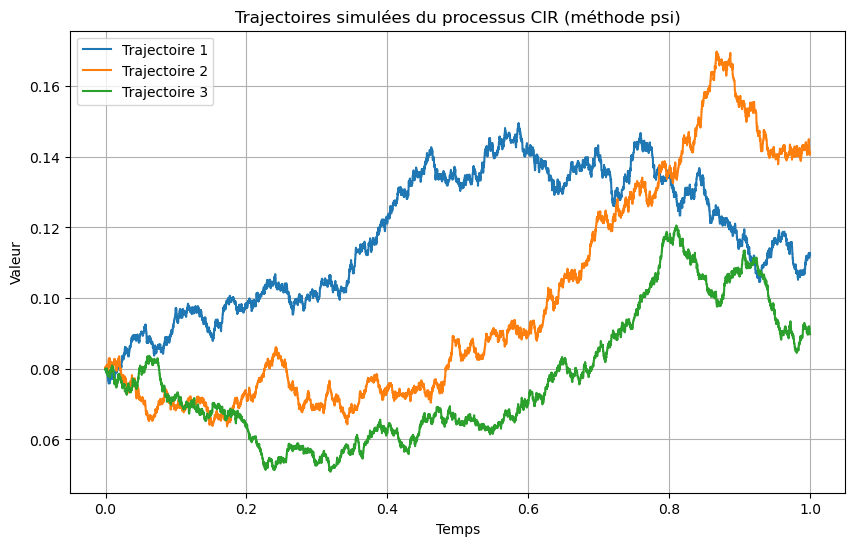

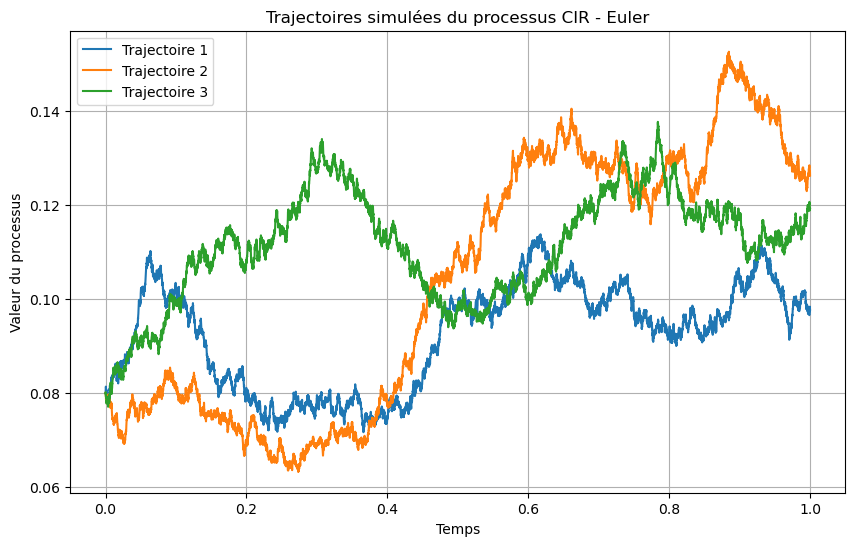

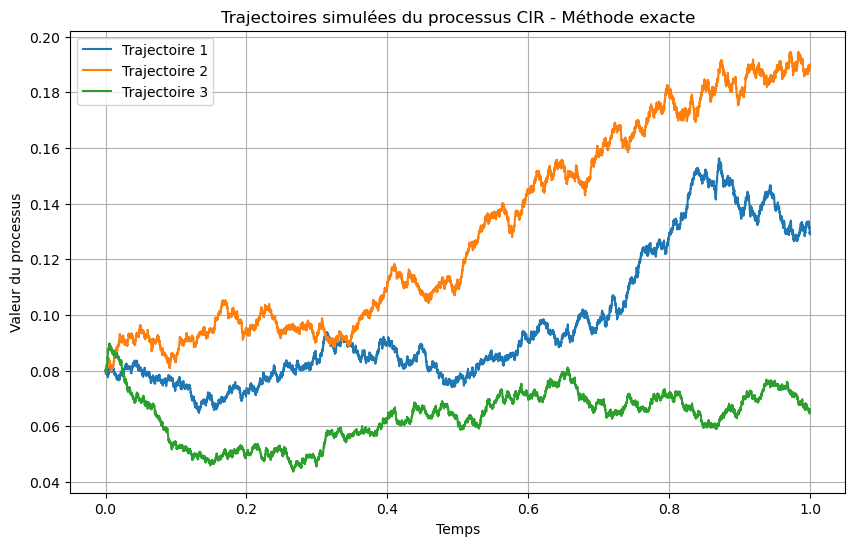

In [199]:
# Parameters for the simulations
a = 0.05
k = 0.15
sigma = 0.1
xi0 = 0.08
T = 1
N = 10000

rho = np.array([0.06, 1.05, 1.79, 2.52, 3.25])
gamma = np.array([0.96, 0.07, 0.04, 0.03, 0.02])

print("G0*sigma^2 =", sum(gamma)*sigma**2)
print("4*a =", 4*a)

# Définition du modèle
cir = CIRProcess(a, k, sigma, rho, gamma, 0, len(rho))

n_trajectories = 3
times = np.linspace(0, T, N + 1)

# Simulation avec méthode simulate_path (méthode psi)
paths = cir.simulate_path(xi0, T, N, n=n_trajectories, seed=42)
plt.figure(figsize=(10, 6))
for i in range(n_trajectories):
    plt.plot(times, paths[i], label=f'Trajectoire {i+1}')
plt.title("Trajectoires simulées du processus CIR (méthode psi)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)
plt.legend()
plt.show()

# Simulation avec méthode Euler
paths_euler = cir.simulate_path_euler(xi0, T, N, n=n_trajectories, seed=42)
plt.figure(figsize=(10, 6))
for i in range(n_trajectories):
    plt.plot(times, paths_euler[i], label=f'Trajectoire {i+1}')
plt.title("Trajectoires simulées du processus CIR - Euler")
plt.xlabel("Temps")
plt.ylabel("Valeur du processus")
plt.grid(True)
plt.legend()
plt.show()

# Simulation avec méthode exacte
paths_exact = cir.simulate_path_exact(xi0, T, N, n=n_trajectories, seed=42)
plt.figure(figsize=(10, 6))
for i in range(n_trajectories):
    plt.plot(times, paths_exact[i], label=f'Trajectoire {i+1}')
plt.title("Trajectoires simulées du processus CIR - Méthode exacte")
plt.xlabel("Temps")
plt.ylabel("Valeur du processus")
plt.grid(True)
plt.legend()
plt.show()


Temps Euler: 0.489s, Moyenne: 0.18756, Variance: 0.00154
Temps Phi: 0.520s, Moyenne: 0.18735, Variance: 0.00158
Temps Exacte: 0.998s, Moyenne: 0.19973, Variance: 0.00164


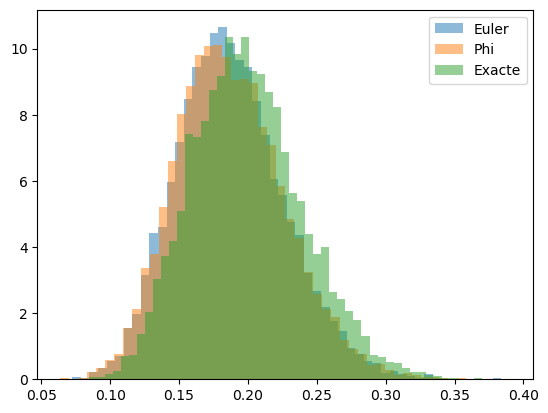

In [190]:

import time
import matplotlib.pyplot as plt

# Paramètres
x0 = 0.1
T = 1.0
N = 1000
n_paths = 10000

cir = CIRProcess(a=0.1, k=0.15, sigma=0.1, rho=rho, gamma=gamma, x0=x0, dim=len(rho))

# Simulation Euler
start = time.time()
paths_euler = cir.simulate_path_euler(x0, T, N, n=n_paths, seed=42)
time_euler = time.time() - start

# Simulation Phi
start = time.time()
paths_phi = cir.simulate_path(x0, T, N, n=n_paths, seed=42)
time_phi = time.time() - start

# Simulation Exacte
start = time.time()
paths_exact = cir.simulate_path_exact(x0, T, N, n=n_paths, seed=42)
time_exact = time.time() - start

# Moyennes à T
mean_euler = np.mean(paths_euler[:, -1])
mean_phi = np.mean(paths_phi[:, -1])
mean_exact = np.mean(paths_exact[:, -1])

# Variances à T
var_euler = np.var(paths_euler[:, -1])
var_phi = np.var(paths_phi[:, -1])
var_exact = np.var(paths_exact[:, -1])

print(f"Temps Euler: {time_euler:.3f}s, Moyenne: {mean_euler:.5f}, Variance: {var_euler:.5f}")
print(f"Temps Phi: {time_phi:.3f}s, Moyenne: {mean_phi:.5f}, Variance: {var_phi:.5f}")
print(f"Temps Exacte: {time_exact:.3f}s, Moyenne: {mean_exact:.5f}, Variance: {var_exact:.5f}")

# Histogrammes
plt.hist(paths_euler[:, -1], bins=50, alpha=0.5, label='Euler', density=True)
plt.hist(paths_phi[:, -1], bins=50, alpha=0.5, label='Phi', density=True)
plt.hist(paths_exact[:, -1], bins=50, alpha=0.5, label='Exacte', density=True)
plt.legend()
plt.show()


### Prix du ZC

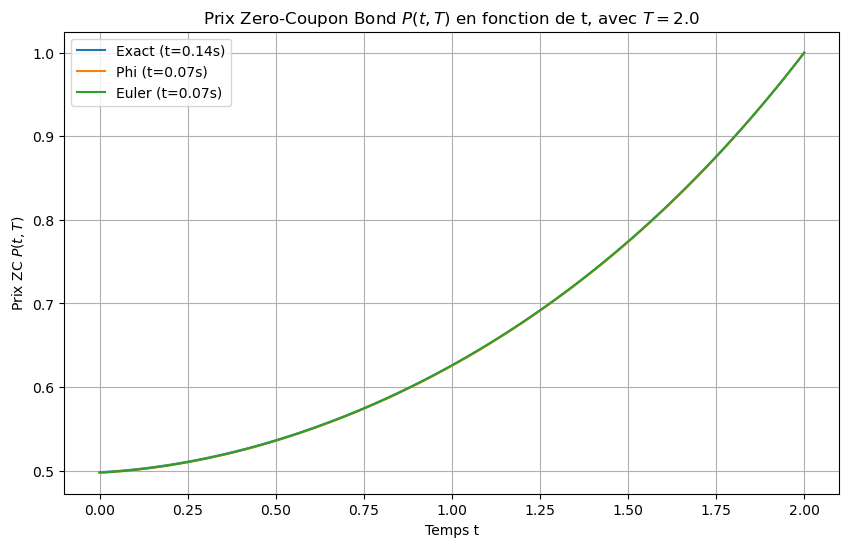

Temps simulation + calcul prix Exact : 0.14 s
Temps simulation + calcul prix Phi   : 0.07 s
Temps simulation + calcul prix Euler : 0.07 s


In [192]:
def prix_ZC_tT(paths, dt):
    n, Np1 = paths.shape
    N = Np1 - 1

    prix_tT = np.zeros(N + 1)

    for i in range(N + 1):
        integrale = np.sum(paths[:, i:N], axis=1) * dt
        prix_tT[i] = np.mean(np.exp(-integrale))

    return prix_tT

# Paramètres
a, k, sigma, rho, gamma = 0.5, 0.7, 0.3, 0, [1]
cir = CIRProcess(a, k, sigma, rho, gamma, x0, 1)

x0 = 0.05
T = 2.0
N = 100
n = 10000
dt = T / N
times = np.linspace(0, T, N + 1)

# Exact
start = time.time()
paths_exact = cir.simulate_path_exact(x0, T, N, n, seed=42)
prix_exact = prix_ZC_tT(paths_exact, dt)
time_exact = time.time() - start

# Phi
start = time.time()
paths_phi = cir.simulate_path(x0, T, N, n, seed=42)
prix_phi = prix_ZC_tT(paths_phi, dt)
time_phi = time.time() - start

# Euler
start = time.time()
paths_euler = cir.simulate_path_euler(x0, T, N, n, seed=42)
prix_euler = prix_ZC_tT(paths_euler, dt)
time_euler = time.time() - start

# Affichage des courbes
plt.figure(figsize=(10,6))
plt.plot(times, prix_exact, label=f"Exact (t={time_exact:.2f}s)")
plt.plot(times, prix_phi, label=f"Phi (t={time_phi:.2f}s)")
plt.plot(times, prix_euler, label=f"Euler (t={time_euler:.2f}s)")
plt.xlabel("Temps t")
plt.ylabel("Prix ZC $P(t,T)$")
plt.title(f"Prix Zero-Coupon Bond $P(t,T)$ en fonction de t, avec $T={T}$")
plt.legend()
plt.grid()
plt.show()

# Affichage des temps dans la console
print(f"Temps simulation + calcul prix Exact : {time_exact:.2f} s")
print(f"Temps simulation + calcul prix Phi   : {time_phi:.2f} s")
print(f"Temps simulation + calcul prix Euler : {time_euler:.2f} s")



Prix du ZC vs pas de temps

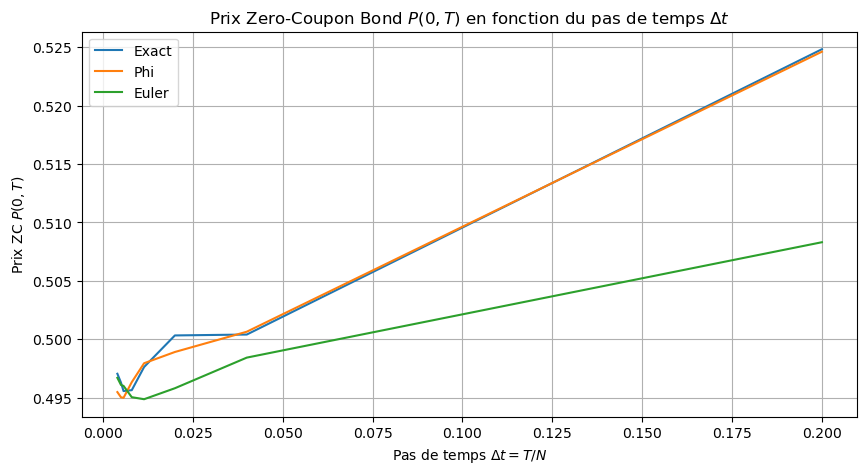

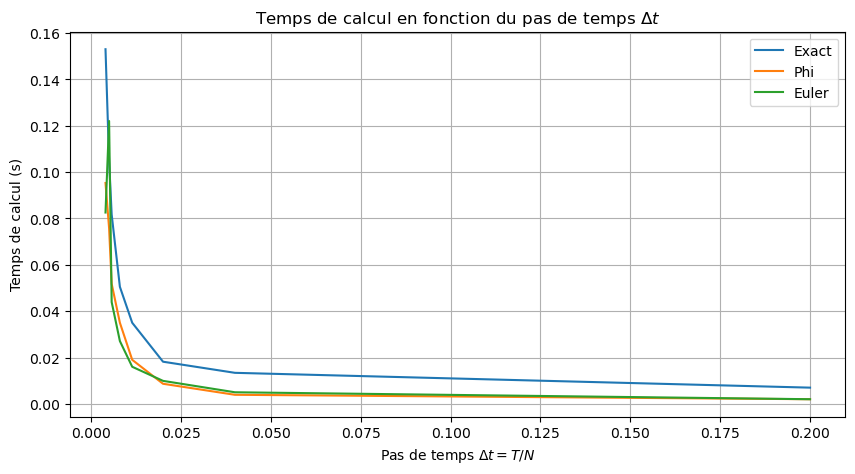

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import time

def prix_ZC_0T(paths, dt):
    # Retourne uniquement le prix P(0,T) : prix_tT[0]
    prix_tT = prix_ZC_tT(paths, dt)
    return prix_tT[0]

# Paramètres constants
x0 = 0.05
T = 2.0
n = 1000  # nombre trajectoires fixe pour comparaison stable

a, k, sigma, rho, gamma = 0.5, 0.7, 0.3, 0, [1]
cir = CIRProcess(a, k, sigma, rho, gamma, x0, 1)

N_values = [10, 50, 100, 175, 250, 350, 400, 500]

prix_exact_list = []
prix_phi_list = []
prix_euler_list = []

time_exact_list = []
time_phi_list = []
time_euler_list = []

dt_values = []

for N in N_values:
    dt = T / N
    dt_values.append(dt)

    # Exact
    start = time.time()
    paths_exact = cir.simulate_path_exact(x0, T, N, n, seed=42)
    prix_exact = prix_ZC_0T(paths_exact, dt)
    time_exact = time.time() - start

    prix_exact_list.append(prix_exact)
    time_exact_list.append(time_exact)

    # Phi
    start = time.time()
    paths_phi = cir.simulate_path(x0, T, N, n, seed=42)
    prix_phi = prix_ZC_0T(paths_phi, dt)
    time_phi = time.time() - start

    prix_phi_list.append(prix_phi)
    time_phi_list.append(time_phi)

    # Euler
    start = time.time()
    paths_euler = cir.simulate_path_euler(x0, T, N, n, seed=42)
    prix_euler = prix_ZC_0T(paths_euler, dt)
    time_euler = time.time() - start

    prix_euler_list.append(prix_euler)
    time_euler_list.append(time_euler)

# Affichage des prix P(0,T) en fonction de dt = T/N
plt.figure(figsize=(10,5))
plt.plot(dt_values, prix_exact_list, label='Exact')
plt.plot(dt_values, prix_phi_list, label='Phi')
plt.plot(dt_values, prix_euler_list, label='Euler')
plt.xlabel('Pas de temps $\\Delta t = T/N$')
plt.ylabel('Prix ZC $P(0,T)$')
plt.title('Prix Zero-Coupon Bond $P(0,T)$ en fonction du pas de temps $\\Delta t$')
plt.legend()
plt.grid()
plt.show()

# Affichage des temps de calcul en fonction de dt = T/N
plt.figure(figsize=(10,5))
plt.plot(dt_values, time_exact_list, label='Exact')
plt.plot(dt_values, time_phi_list, label='Phi')
plt.plot(dt_values, time_euler_list, label='Euler')
plt.xlabel('Pas de temps $\\Delta t = T/N$')
plt.ylabel('Temps de calcul (s)')
plt.title('Temps de calcul en fonction du pas de temps $\\Delta t$')
plt.legend()
plt.grid()
plt.show()


## Simulation du processus CIR multifacteur

G0*sigma^2 = 0.27
4*a = 0.08


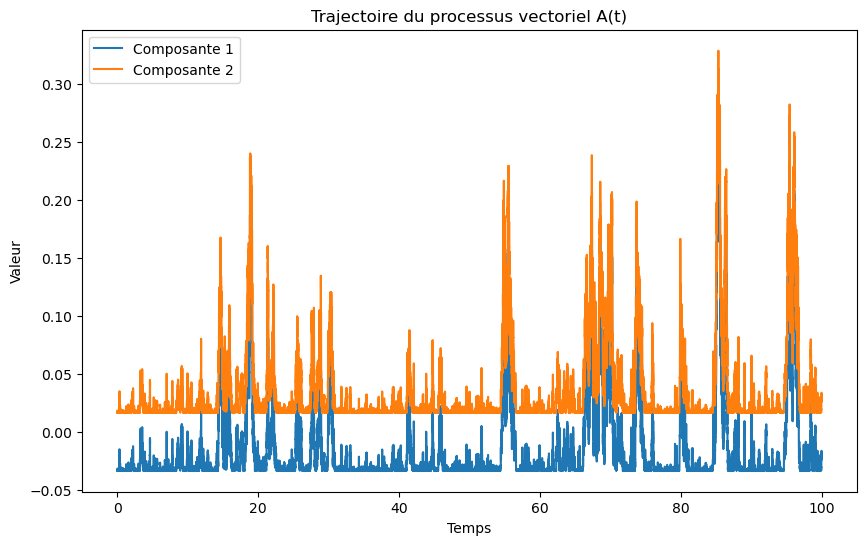

In [287]:
# Parameters for the simulations
a = 0.02
k = 0.3
sigma = 0.3
x0 = 0.
T = 100
N = 100000

rho = np.array([1, 10])
gamma = np.array([1, 2])

# Conditions initiales
X0 = np.array([0.05, 0.1])
x = x0
for i in range(len(rho)):
    x+=gamma[i]*X0[i]

print("G0*sigma^2 =", sum(gamma)*sigma**2)
print("4*a =", 4*a)

# Définition du modèle
dim = 2
cir = CIRProcess(a, k, sigma, rho, gamma, x, dim)

# Simulations et affichage
path = cir.simulate_path(x0, T, N, 1)[0]

# Calcul de la trajectoire vectorielle A_path (N+1, dim)
A_path = np.zeros((N+1, dim))
for i in range(N+1):
    A_path[i, :] = cir.A(X0, path[i], x0)

# Affichage
time_grid = np.linspace(0, T, N+1)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for j in range(dim):
    plt.plot(time_grid, A_path[:, j], label=f'Composante {j+1}')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.title('Trajectoire du processus vectoriel A(t)')
plt.legend()
plt.show()




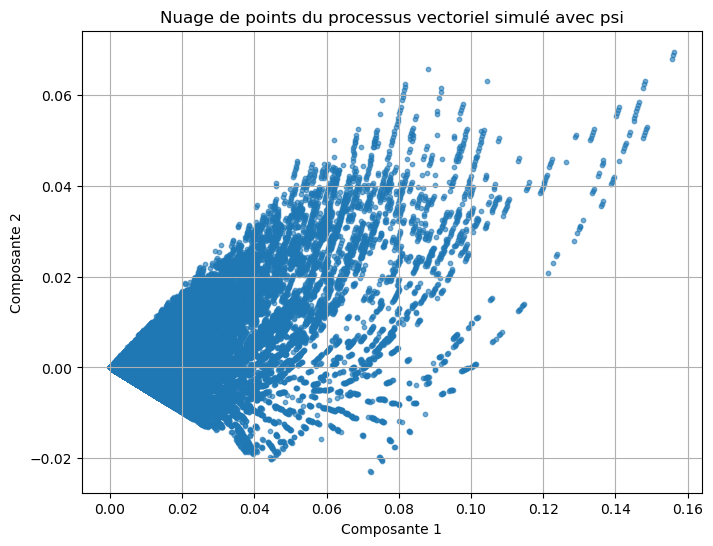

In [291]:
# Simulation de la trajectoire vectorielle avec le schéma psi
path = cir.simulate_multifactor(x0, T, N)

# Affichage sous forme de nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(path[:, 0], path[:, 1], s=10, alpha=0.6)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('Nuage de points du processus vectoriel simulé avec psi')
plt.grid(True)
plt.show()

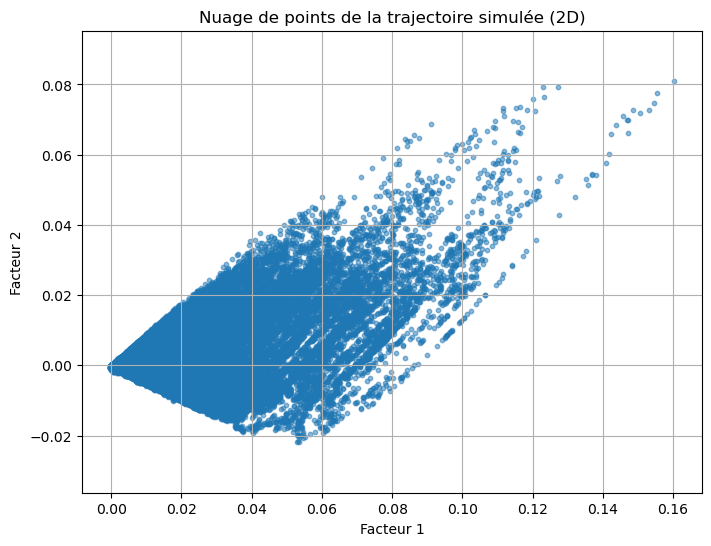

In [293]:
Y = cir.simulate_multifactor_euler(N=N, T=100, num_simulations=1)

traj = Y[:, 0, :]  # Extraire la trajectoire (shape : (N, dim))

# Nuage de points 2D

plt.figure(figsize=(8, 6))
plt.scatter(traj[:, 0], traj[:, 1], s=10, alpha=0.5)
plt.title("Nuage de points de la trajectoire simulée (2D)")
plt.xlabel("Facteur 1")
plt.ylabel("Facteur 2")
plt.grid(True)
plt.axis('equal')
plt.show()


## Multifactor Heston model